### Import

In [32]:
import pandas as pd
import numpy as np
import plotly.express as px
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

# directory
%cd '/content/gdrive/My Drive/Oxford/ML_for_Social_Good'

# import my dfs
#df = pd.read_csv('preprocessed_with_outlier_classif.csv')
#df2 = pd.read_csv('cleaned_fulldf.csv')

# import Jess' dfs - easier bc has some variables that I don't have
train = pd.read_csv('dftrain.csv')
test = pd.read_csv('dftest.csv')
train["Set"] = "train"
test["Set"] = "test"
df = pd.concat([train, test],ignore_index=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Oxford/ML_for_Social_Good


### Shapley values — selecting variables for encodings

**Interpretation of Shapley values**: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.


**Important features** (shapley value > 0.1 or < -0.1) (in model "Build Per Acre Only Yield Per Acre Model")

Positive values:
```
BasalDAP
Harv_hand_rent
BasalUrea_per_Acre
BasalDAP_per_Acre
CultLand
TransplantingIrrigationHours_per_Acre
Latitude
2tdUrea_per_Acre
TpIrrigationHours_Imputed
Harv_hand_rent_per_Acre
TillageDate_ModeDiff
NursingDate_ModeDiff
CropCultLand
Days_bw_Nurs_Harv
1appDaysUrea
2tdUrea
Days_bw_Nurs_Till_ModeDiff
SowTransplantDate_ModeDiff
Days_bw_Nurs_SowTransp
Days_bw_Harv_Thresh
Days_bw_Till_Harv
ThreshingMonth_March
Num_TransDetFactor
```
Negative values:
```
1tdUrea
TpIrrigationHours_Imputed_per_Acre
BasalUrea
CropOrgFYM_per_Acre
Num_TopDressFert
Days_bw_SowTransp_Harv
Num_CropbasalFerts
TransIrriCost
Ganaura_capped
Block_Khaira
Days_bw_Till_Harv_ModeDiff
LandPrepMethod_WetTillagePuddling_True
```


- For categoricals / discrete: go each value, get mean yield (per_acre)
- For continuous: linear regression

In [34]:
subset = df.copy()
subset = subset[["1tdUrea","TpIrrigationHours_Imputed_per_Acre","BasalUrea","CropOrgFYM_per_Acre","Num_TopDressFert","Days_bw_SowTransp_Harv","Num_CropbasalFerts","TransIrriCost",
             "Ganaura_capped","Block_Khaira","Days_bw_Till_Harv_ModeDiff","LandPrepMethod_WetTillagePuddling_True","BasalDAP","Harv_hand_rent","BasalUrea_per_Acre",
             "BasalDAP_per_Acre","CultLand","TransplantingIrrigationHours_per_Acre","Latitude","2tdUrea_per_Acre","TpIrrigationHours_Imputed","Harv_hand_rent_per_Acre",
             "TillageDate_ModeDiff","NursingDate_ModeDiff","CropCultLand","Days_bw_Nurs_Harv","1appDaysUrea","2tdUrea","Days_bw_Nurs_Till_ModeDiff","SowTransplantDate_ModeDiff",
             "Days_bw_Nurs_SowTransp","Days_bw_Harv_Thresh","Days_bw_Till_Harv","ThreshingMonth_March","Num_TransDetFactor","Yield","Yield_per_Acre"]]
subset

,1tdUrea,TpIrrigationHours_Imputed_per_Acre,BasalUrea,CropOrgFYM_per_Acre,Num_TopDressFert,Days_bw_SowTransp_Harv,Num_CropbasalFerts,TransIrriCost,Ganaura_capped,Block_Khaira,Days_bw_Till_Harv_ModeDiff,LandPrepMethod_WetTillagePuddling_True,BasalDAP,Harv_hand_rent,BasalUrea_per_Acre,BasalDAP_per_Acre,CultLand,TransplantingIrrigationHours_per_Acre,Latitude,2tdUrea_per_Acre,TpIrrigationHours_Imputed,Harv_hand_rent_per_Acre,TillageDate_ModeDiff,NursingDate_ModeDiff,CropCultLand,Days_bw_Nurs_Harv,1appDaysUrea,2tdUrea,Days_bw_Nurs_Till_ModeDiff,SowTransplantDate_ModeDiff,Days_bw_Nurs_SowTransp,Days_bw_Harv_Thresh,Days_bw_Till_Harv,ThreshingMonth_March,Num_TransDetFactor,Yield,Yield_per_Acre
0,0.569942,-0.102832,1.274656,-0.124686,0.333333,0.425233,0.20,-0.436564,-0.293083,False,-0.267158,False,-1.123597,-0.764921,1.359032,-1.497804,0.540950,-0.122392,0.157991,-0.565827,-0.067822,-0.706799,0.611515,-0.005871,0.545631,0.213611,0.229730,-0.475738,0.555725,-0.409739,-0.557586,-1.175962,-0.267158,False,1.0,600.0,1920.000000
1,1.124328,-0.102832,0.257140,-0.124686,0.333333,0.939948,0.40,-0.619834,-0.293083,False,0.313804,True,0.588250,-0.760251,0.206548,0.416091,-0.083018,-0.122392,0.093092,-0.565827,-0.067822,-0.703326,0.468083,-0.593156,0.045474,1.033835,0.513514,-0.475738,0.886315,-0.495226,0.134659,-0.033887,0.313804,False,1.0,600.0,1920.000000
2,-0.538828,-0.054147,-0.760376,-0.093310,0.333333,0.579647,0.20,-0.729796,-0.171775,False,2.162322,False,-0.667104,-0.017660,-0.945936,-0.421238,-0.608464,-0.062603,0.000000,-0.565827,-0.091895,0.465418,-0.822810,-0.593156,-0.526135,1.905324,0.864865,-0.475738,-0.303807,1.556453,2.903640,0.005495,2.162322,False,0.6,225.0,1518.750000
3,-0.538828,-0.093980,-0.455122,-0.124686,0.333333,1.454664,0.40,NaN,-0.171775,False,2.373581,False,-0.438858,-0.391291,-0.459732,-0.421238,-0.444262,NaN,0.000000,-0.565827,-0.091895,-0.316060,-1.826837,-0.844849,-0.347507,1.546476,0.054054,-0.475738,-1.031104,-0.751686,0.134659,-0.112651,2.373581,False,1.0,468.0,2106.000000
4,2.233098,-0.088669,2.292172,-0.124686,0.333333,1.197306,0.40,-0.192204,-0.293083,False,0.525063,True,0.588250,-0.764921,1.359032,-0.221874,1.033557,-0.104999,0.157991,-0.565827,0.028471,-0.706799,0.539799,-0.509258,1.260142,1.238892,0.337838,-0.475738,0.886315,-0.495226,0.019285,-1.097198,0.525063,False,0.8,550.0,1173.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,0.278500,-0.191603,-0.729965,-0.117477,0.250000,0.721043,0.25,-0.465918,-0.294022,True,0.329438,False,0.201986,0.549207,-0.924960,-0.527070,-0.373484,-0.197400,0.052707,0.791673,-0.141518,0.111510,0.849975,0.707541,-0.409673,0.570755,0.343750,1.922635,0.218401,0.419273,-0.431284,-0.333175,0.329438,False,0.6,NaN,NaN
5156,-1.054390,-0.163027,-0.729965,-0.023075,0.000000,-1.514628,0.25,-0.238662,-0.294022,False,-1.302247,True,1.043527,-0.101927,-0.924960,2.806942,-0.170486,-0.168250,0.298935,-0.576347,-0.169309,0.135402,-0.278078,1.048264,-0.495577,-2.111254,NaN,-0.483768,-1.082201,-0.020309,-1.472432,-1.010019,-1.302247,False,0.8,NaN,NaN
5157,-0.439210,-0.142071,-0.729965,0.339164,0.250000,0.029050,0.50,-0.465918,-0.294022,False,-0.565357,False,-0.429169,0.028300,-0.924960,0.248282,-0.779479,-0.146874,1.000000,0.677672,-0.169309,0.748640,-0.348581,-0.740534,-0.968046,-0.323248,0.453125,0.117833,0.218401,-1.426973,-0.894016,-0.611876,-0.565357,False,0.6,NaN,NaN
5158,-0.849330,-0.175601,-0.729965,-0.143821,0.500000,0.614582,0.00,0.215852,-0.294022,False,0.066263,False,-1.060325,-0.414471,-0.924960,-1.457492,-0.779479,-0.181076,0.065242,-0.074740,-0.169309,-0.526895,0.779471,-0.740534,-0.667384,1.149228,0.453125,-0.082701,1.258883,0.067607,1.072597,1.339028,0.066263,False,0.4,NaN,NaN


In [35]:
#for col in subset.columns:
#  print(col, subset[col].value_counts())

In [36]:
# list of cat / discrete variables
catcols = ["Num_TopDressFert","Num_CropbasalFerts","Block_Khaira","LandPrepMethod_WetTillagePuddling_True","Latitude","ThreshingMonth_March","Num_TransDetFactor"]

# list of continuous variables
continuouscols = ["1tdUrea","TpIrrigationHours_Imputed_per_Acre","BasalUrea","CropOrgFYM_per_Acre","Days_bw_SowTransp_Harv","TransIrriCost","Ganaura_capped",
                  "Days_bw_Till_Harv_ModeDiff","BasalDAP","Harv_hand_rent_per_Acre","BasalUrea_per_Acre","BasalDAP_per_Acre","CultLand","TransplantingIrrigationHours_per_Acre",
                  "2tdUrea_per_Acre","TillageDate_ModeDiff","NursingDate_ModeDiff","CropCultLand","Days_bw_Nurs_Harv","1appDaysUrea","2tdUrea","Days_bw_Nurs_Till_ModeDiff",
                  "SowTransplantDate_ModeDiff","Days_bw_Nurs_SowTransp","Days_bw_Harv_Thresh","Days_bw_Till_Harv"
                  ]

### Frequency encoding for categorical / discrete variables

In [37]:
for col in catcols:
  dico = subset[col].value_counts().to_dict()
  newlabel = str(col) + str("_freqencoding")
  subset[newlabel] = subset[col]
  subset[newlabel] = subset[newlabel].replace(dico)

### Yield_per_Acre mean encoding for categorical / discrete variables

In [39]:
# NaNs are when all rows with that value are in the test set
df.groupby("Num_TopDressFert")["Yield_per_Acre"].mean()
subset.groupby("Num_CropbasalFerts")["Yield_per_Acre"].mean()

# NOTE: need to fix these 2 variables, otherwise the encodings are meaningless (for both mean encoding and frequency encoding)

Num_CropbasalFerts
0.00    1667.604965
0.20    1947.782024
0.25            NaN
0.40    1989.727984
0.50            NaN
0.60    2635.738319
0.75            NaN
0.80    1940.714286
1.00    1943.333333
Name: Yield_per_Acre, dtype: float64

In [40]:
for col in catcols:
  dico = subset.groupby([col])["Yield_per_Acre"].mean().to_dict()
  newlabel = str(col) + str("_meanencoding")
  subset[newlabel] = subset[col]
  subset[newlabel] = subset[newlabel].replace(dico)

### Linear regression for continuous variables

In [41]:
# locating columns that have NaNs

for col in continuouscols:
  print(col)
  print(train[col].isnull().sum())

# -> TransIrriCost, TransplantingIrrigationHours_per_Acre, NursingDate_ModeDiff, Days_bw_Nurs_Harv, 1appDaysUrea, Days_bw_Nurs_Till_ModeDiff, Days_bw_Nurs_SowTransp

1tdUrea
0
TpIrrigationHours_Imputed_per_Acre
0
BasalUrea
0
CropOrgFYM_per_Acre
0
Days_bw_SowTransp_Harv
0
TransIrriCost
882
Ganaura_capped
0
Days_bw_Till_Harv_ModeDiff
0
BasalDAP
0
Harv_hand_rent_per_Acre
0
BasalUrea_per_Acre
0
BasalDAP_per_Acre
0
CultLand
0
TransplantingIrrigationHours_per_Acre
193
2tdUrea_per_Acre
0
TillageDate_ModeDiff
0
NursingDate_ModeDiff
83
CropCultLand
0
Days_bw_Nurs_Harv
83
1appDaysUrea
556
2tdUrea
0
Days_bw_Nurs_Till_ModeDiff
83
SowTransplantDate_ModeDiff
0
Days_bw_Nurs_SowTransp
83
Days_bw_Harv_Thresh
0
Days_bw_Till_Harv
0


In [43]:
have_nans = ["TransIrriCost", "TransplantingIrrigationHours_per_Acre", "NursingDate_ModeDiff", "Days_bw_Nurs_Harv", "1appDaysUrea", "Days_bw_Nurs_Till_ModeDiff",
             "Days_bw_Nurs_SowTransp"]

continuouscols2 = [x for x in continuouscols if x not in have_nans]

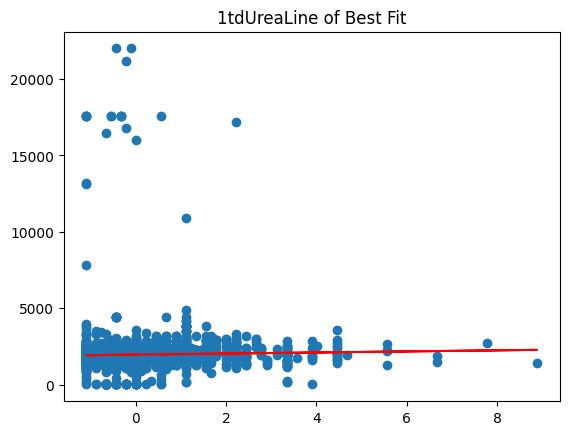

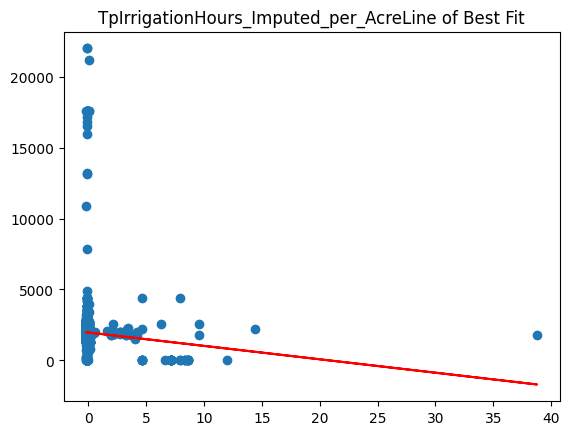

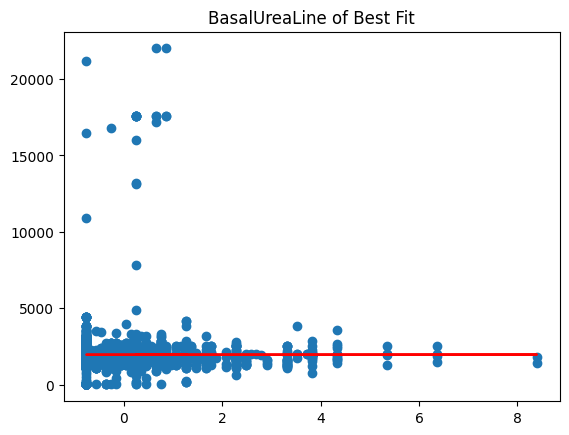

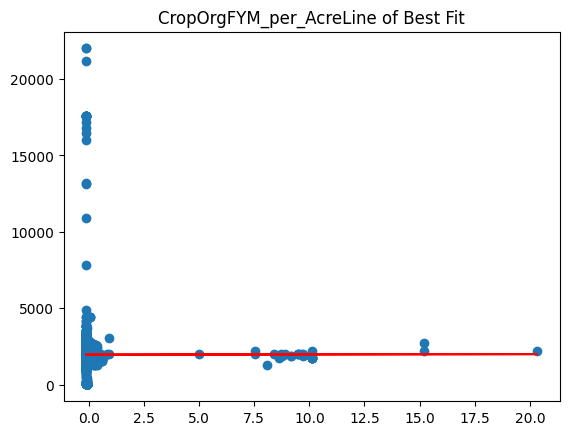

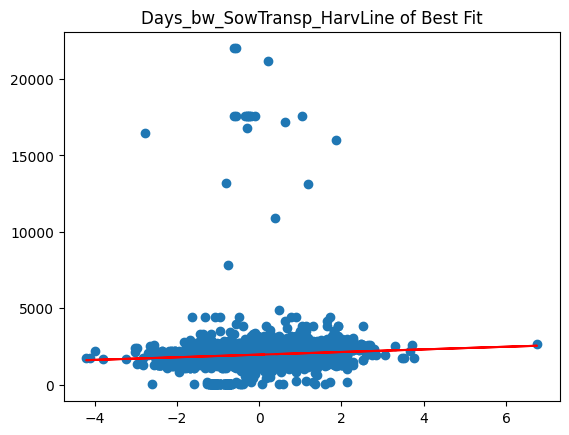

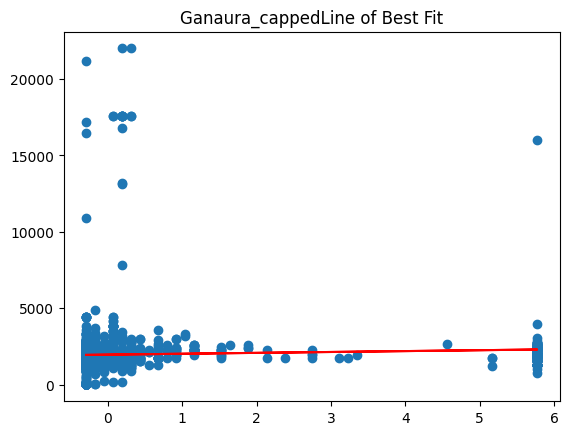

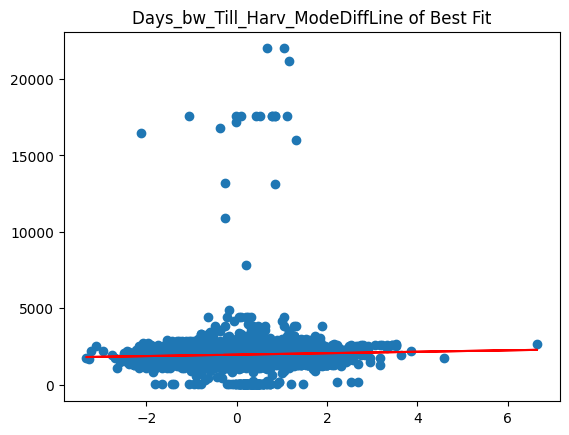

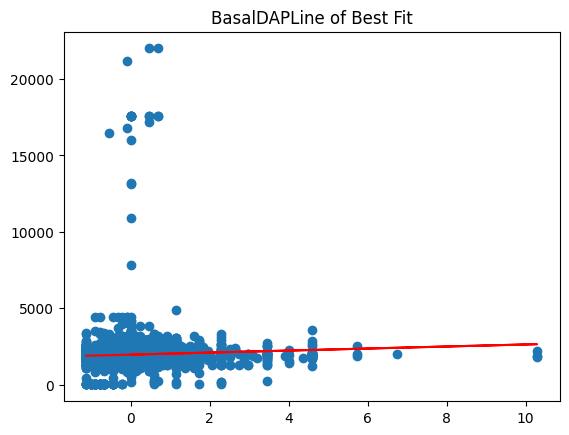

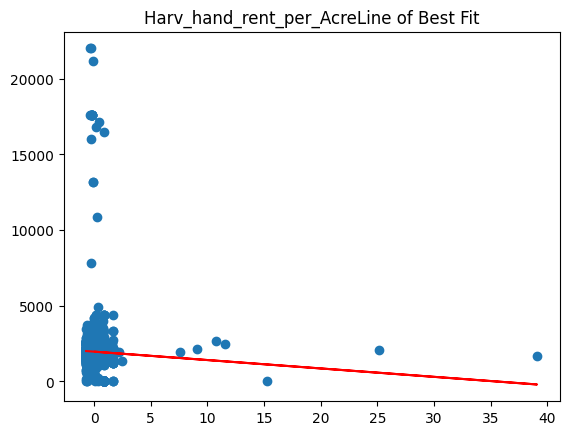

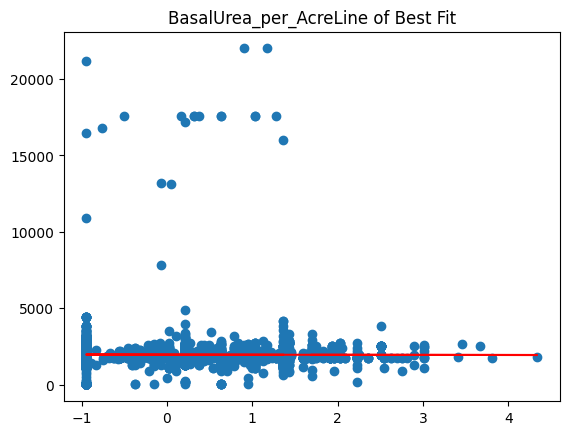

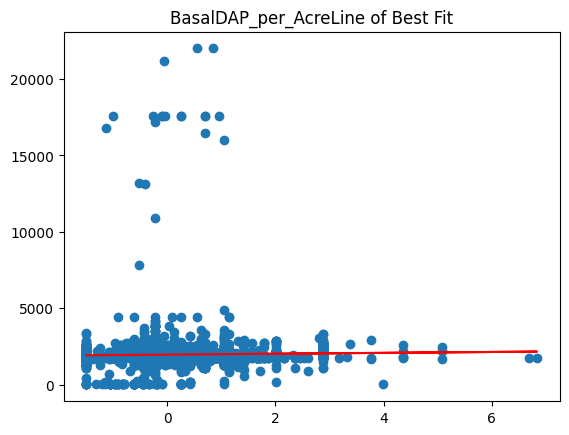

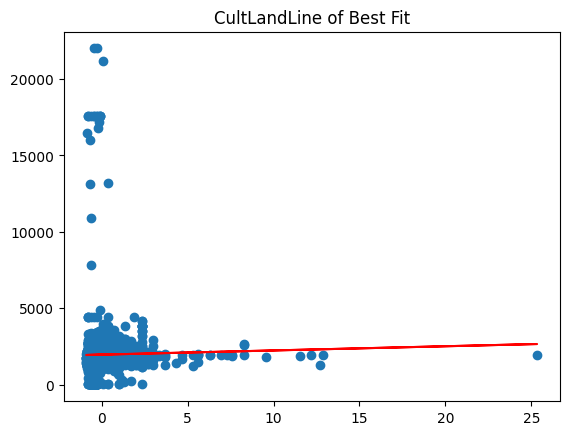

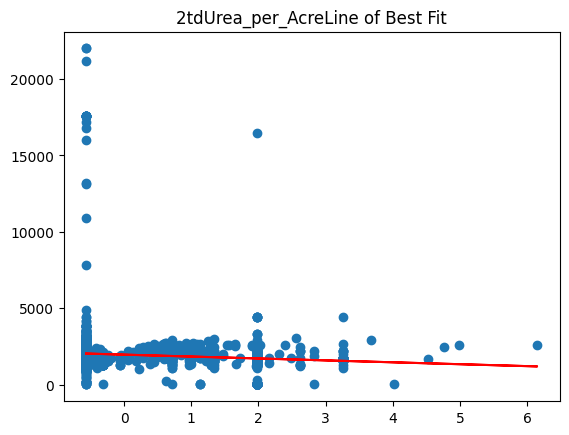

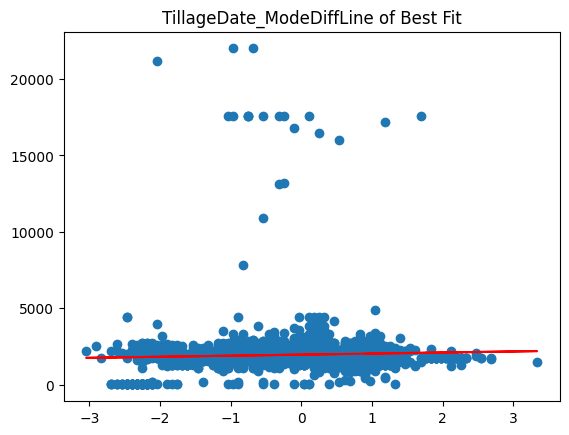

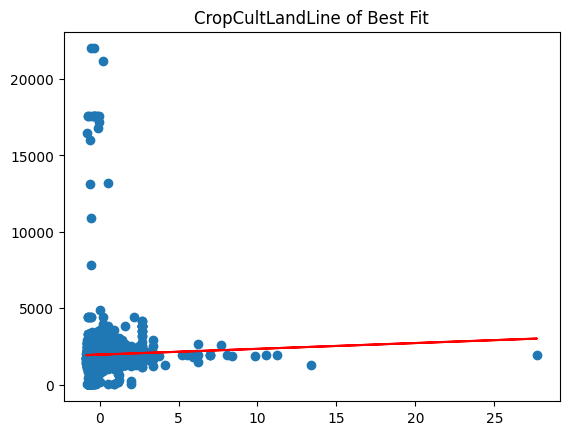

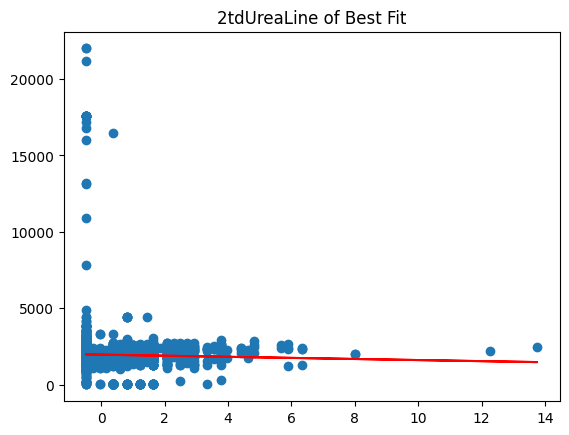

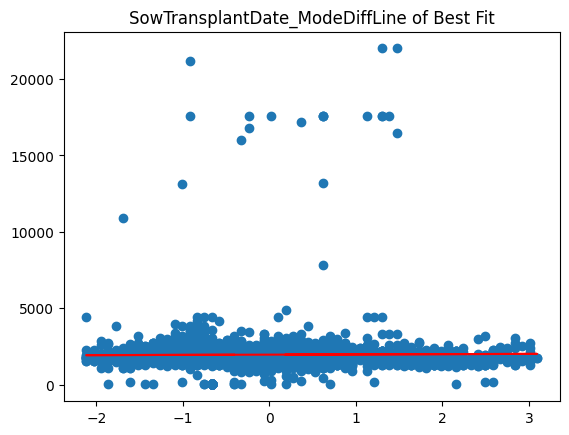

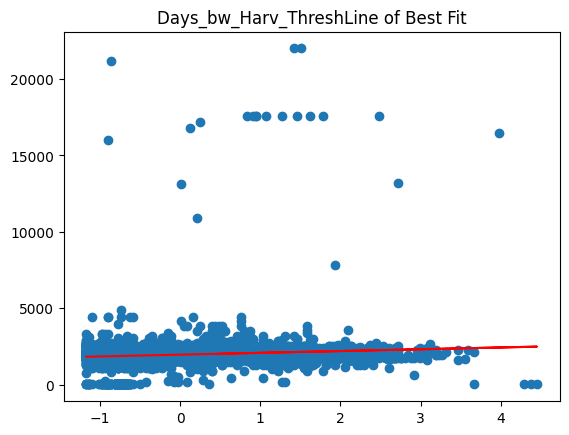

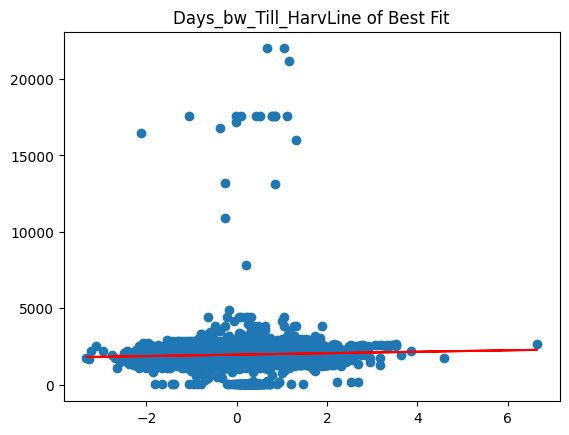

In [44]:
# Linear regression

for col in continuouscols2:
  # Perform linear regression
  slope, intercept = np.polyfit(train[col], train['Yield_per_Acre'], 1)

  # Plot
  plt.scatter(train[col], train['Yield_per_Acre'])
  plt.plot(train[col], slope * train[col] + intercept, color='red')
  plt.title(str(col) + ' Line of Best Fit')
  plt.show()

In [47]:
# Listing columns for which the linear regression might be helpful
linearregression = ["Days_bw_Till_Harv","Days_bw_Harv_Thresh","SowTransplantDate_ModeDiff","TillageDate_ModeDiff","BasalDAP_per_Acre","BasalUrea_per_Acre",
                    "Ganaura_capped","Days_bw_SowTransp_Harv","1tdUrea"]

In [62]:
from sklearn.linear_model import LinearRegression

for col in linearregression:
  # Train using the train set
  lr = LinearRegression()
  lr.fit(train[col].values.reshape(-1, 1), train["Yield_per_Acre"])
  # Predictions for entire dataset
  pred = lr.predict(subset[col].values.reshape(-1, 1))
  newlabel = str(col) + str("_LRpred")
  subset[newlabel] = pred

### Listing the newly added variables

In [ ]:
newfeatures = ['Num_TopDressFert_freqencoding',
               'Num_CropbasalFerts_freqencoding',
               'Block_Khaira_freqencoding',
               'LandPrepMethod_WetTillagePuddling_True_freqencoding',
               'Latitude_freqencoding',
               'ThreshingMonth_March_freqencoding',
               'Num_TransDetFactor_freqencoding',
               'Num_TopDressFert_meanencoding',
               'Num_CropbasalFerts_meanencoding',
               'Block_Khaira_meanencoding',
               'LandPrepMethod_WetTillagePuddling_True_meanencoding',
               'Latitude_meanencoding',
               'ThreshingMonth_March_meanencoding',
               'Num_TransDetFactor_meanencoding',
               'Days_bw_Till_Harv_LRpred',
               'Days_bw_Harv_Thresh_LRpred',
               'SowTransplantDate_ModeDiff_LRpred',
               'TillageDate_ModeDiff_LRpred',
               'BasalDAP_per_Acre_LRpred',
               'BasalUrea_per_Acre_LRpred',
               'Ganaura_capped_LRpred',
               'Days_bw_SowTransp_Harv_LRpred',
               '1tdUrea_LRpred'
               ]